# 3/19/20 

In [26]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob
import re

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

In [61]:
from scipy.special import erfc, expit
from iminuit import Minuit
import matplotlib.pyplot as plt

class PhotonEff():
    def __init__(self):
        self.df = None
        self.histos = None
        self.fit_name = None
        self.fit_results = dict()
        self.good_fits = dict()
    def __variance(self, k, n):
        return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2
    def __chi2(self, mu, s, c, N, a):
        xedges, points, errs = self.get_histo_by_name(self.fit_name)
        return np.sum( np.square((points - self.sigFunc(xedges, mu, s, c, N, a))/errs) )
    
    def sigFunc(self, x, mu, s, c, N, a):
        return N*( 1 - expit((x-mu)/s) + c)
#         return N*(c + erfc((x-mu)/s))
    def get_signal_by_name(self, name, x):
        return self.sigFunc( x, *(self.fit_results[name][0]) )
    def get_histo_by_name(self, name):
        xedges = self.histos[name][0]
        points = self.histos[name][1]
        errs = self.histos[name][2]
        return (xedges, points, errs)
    def fit_histo_by_name(self, name):
        self.fit_name = name
        parameters = {
            'mu':0.02,
            's':1/25,
            'c':0.04,
            'N':0.75,
            'a':1,
        }
        limits = {
            'limit_mu' : [0, 1],
            'limit_s' : [0,1],
            'limit_c' : [0,1],
            'limit_N' : [0,1],
            'limit_a' : [0,10],
        }
        errors = {
            'error_mu' : 0.01,
            'error_s' : 1/25,
            'error_c' : 0.01,
            'error_N' : 0.05,
            'error_a' : 0.1,
        }
        m = Minuit( self.__chi2, **parameters, **limits, **errors, errordef=1)
        m.migrad()
        ndf = len(self.get_histo_by_name(name)[0]) - len(m.np_values())
        print(m.migrad_ok())
        self.good_fits[name] = m.migrad_ok()
        return ( m.np_values(), m.np_errors(), m.fval, ndf )
    def show_histo_by_name(self, name):
        xedges, points, errs = self.get_histo_by_name(name)
        plt.errorbar(xedges, points, yerr=errs, fmt='o')
        x = np.linspace(0, xedges.max(), 100)
        text_string = f"name: {name}\n"
        if name in self.fit_results:
            plt.plot(x,  self.sigFunc(x, *(self.fit_results[name][0]) ) )
            chi2, ndf = self.fit_results[name][2], self.fit_results[name][3]
            text_string += f'$\chi^2$/ndf = {chi2:.2f} / {ndf}\n'
#             text_string += f'$\\mu$ = {self.fit_results[name][0][0]}\n'
        plt.text(0.7*xedges.max(), 0.85*points.max(), text_string)
        plt.xlabel('Photon energy, GeV')
        plt.ylabel('Reg efficiency')
        plt.xlim(0, xedges.max())
        return 
    
    def open(self, *files):
        f = [_ for _ in files ]
        it = uproot.pandas.iterate(f, treepath='mc_passed', reportpath=True)
        self.df = pd.concat([j.assign(name=re.findall(r'_?(\d*.?\d*_?\d+).root',i)[0]) for i,j in it])
    def get_histo(self, df, bins=81):
        xedges = np.linspace(0, df['ph_energy'].max(), bins)
        hpassed, _ = np.histogram(df.query('passed_cuts==True')['ph_energy'], bins=xedges)
        hall, _ = np.histogram(df['ph_energy'], bins=xedges)
        xedges = (xedges[1:] + xedges[:-1])/2
        points = (hpassed+1)/(hall+2)
        errs = np.sqrt( self.__variance(hpassed, hall) )
        return np.array( [xedges, points, errs] )
    def get_histos(self):
        df = self.df
        self.histos = df.groupby('name').apply(lambda x: self.get_histo(x) )
        return self.histos
    def fit_histos(self):
        for name in self.histos.index:
            self.fit_results[name] = self.fit_histo_by_name(name)
        return
    def get_names(self):
        return self.histos.index

In [62]:
p = PhotonEff()
# p.open(*glob('../../outputs/others/trees/*_0.root'))
p.open(*glob('../../outputs/mc19_uniform/trees/*.root'))

In [63]:
p.get_histos();

In [64]:
p.fit_histos()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [65]:
p.get_names()

Index(['537.5_70914', '550.1_70029', '550_70260', '562.5_71178', '575_71544',
       '587.5_71908', '600_72268', '612.5_72545', '612.5_84504', '625_72787',
       '637.5_73035', '641_82925', '650_73374', '662.5_73636', '675_73926',
       '687.5_74169', '700_74366', '712.5_74528', '725_74704', '737.5_74974',
       '750_75459', '762_75730', '775_76033', '787.5_76243', '800_76450',
       '812.5_76723', '825_77131', '837.5_77414', '850_77631', '862.5_77854',
       '875_78066', '887.5_78274', '900_78506', '912.5_78722', '925_78931',
       '936_79212', '945_82528', '950_79625', '951.1_82106', '955_81775',
       '962.5_80068', '975_80603', '978_80506', '987.5_81313'],
      dtype='object', name='name')

In [66]:
p.fit_histo_by_name('550.1_70029')

True


(array([0.01355689, 0.00357246, 0.0194299 , 0.24552995, 1.        ]),
 array([5.63883984e-04, 2.87036065e-04, 3.41888017e-03, 1.11590197e-02,
        5.20646369e+00]),
 46.900709144135234,
 75)

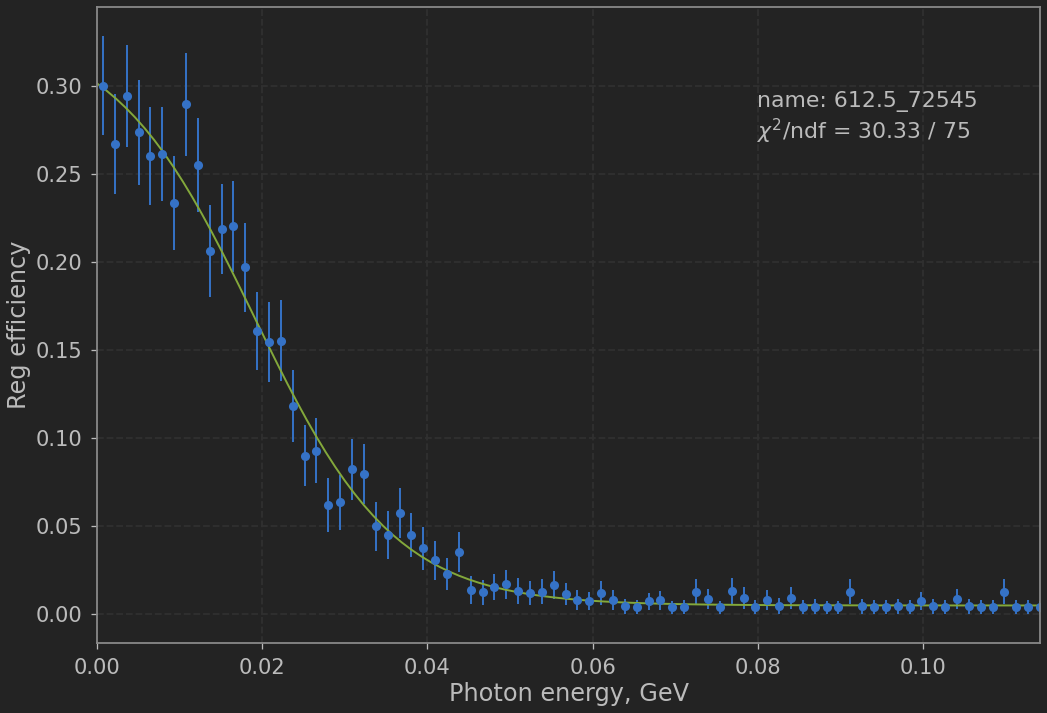

In [70]:
# p.show_histo_by_name('612.5_84504')
p.show_histo_by_name('612.5_72545')

In [71]:
#mu, s, c, N, a
i = 1
chindf_mean = 0
xe = list()
yp = list()
yperr = list()
for e in p.fit_results:
    chindf_mean += p.fit_results[e][2]/p.fit_results[e][3]
    if p.good_fits[e] == False:
        print('Bad fit at', e)
        continue
    xe.append((e))
    yp.append(p.fit_results[e][0][i])
    yperr.append(p.fit_results[e][1][i])
print('Chi2/ndf mean:', chindf_mean/len(xe))

Chi2/ndf mean: 0.5973541153181879


<ErrorbarContainer object of 3 artists>

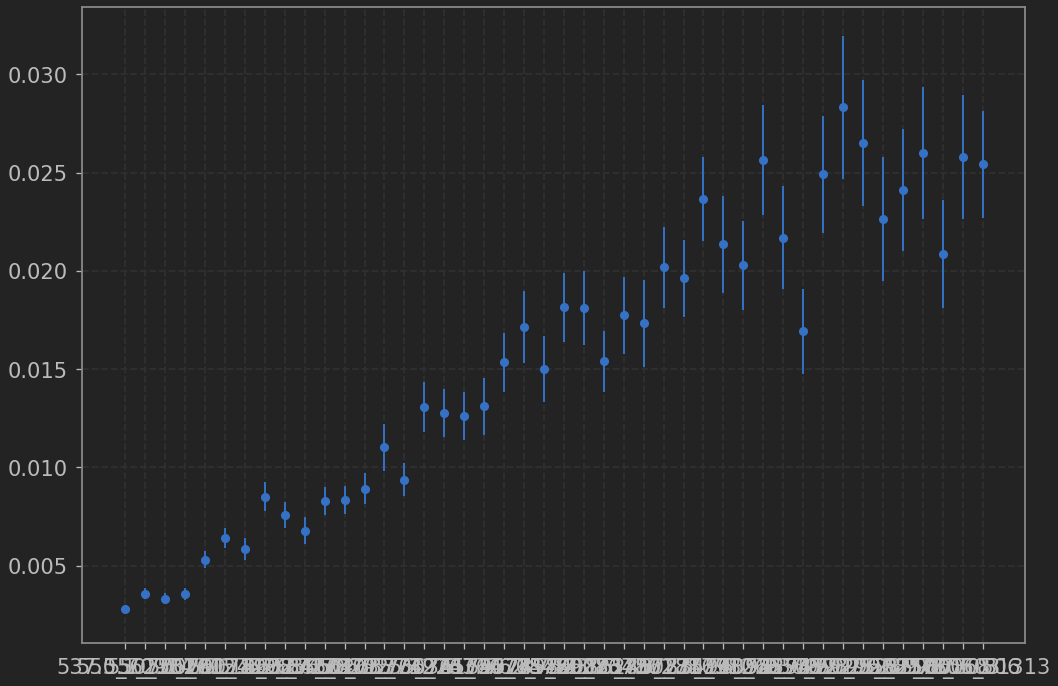

In [72]:
plt.errorbar(xe, yp, yperr, fmt='o')

In [274]:
%ls code

9_radcors.cpp*                      9_radcors_cpp.so*  one_file_handler.py
9_radcors_cpp_ACLiC_dict_rdict.pcm  a.out*             plot_reg_eff_4.py
9_radcors_cpp.d                     cs_klks_cmd2       radcorsnewprog.py


In [73]:
# %load code/radcorsnewprog.py

import scipy.integrate as integrate
import numpy as np

class RadCor:
    alpha = 7.297e-3
    me = 0.511 #MeV
    
    def __init__(self):
        return
    def l(self, E, dE):
        return np.log(E/dE)
    def L(self, s):
        me = self.me
        return np.log(s/(me**2))
    def beta(self, s):
        a = self.alpha
        p = np.pi
        return (2*a/p)*(self.L(s) - 1)
    
    def soft_terms_rad(self, E, dE):
        a = self.alpha
        p = np.pi
        s = 4*(E**2)
        l = self.l(E, dE)
        L = self.L(s)
        
        s1 = -2*l*(L-1) + 3*L/2 + (p**2)/3 - 2
        s2 = (1/2)*((-2*l*(L-1))**2)
        s3 = (3*L/2 + (p**2)/3 - 2)*(-2*l*(L-1))
        s4 = (L**2)*( -l/3 + 11/8 - (p**2)/3 )
        s5 = L*(2*(l**2)/3 + 10*l/9 - 203/48 + 11*(p**2)/12 + 3*1.202)
        s6 = -(4/9)*(l**3) - (10/9)*(l**2) - (2/9)*(28/3 - p**2)*l
        
        result = 1 + (a/p)*s1 + ((a/p)**2)*(s2 + s3 + s4 + s5 + s6)
        return result
    def soft_terms_cs(self, E, cs, dE):
        return self.soft_terms_rad(E, dE)/cs
        
    def F(self, x, s):
        a = self.alpha
        b = self.beta(s)
        p = np.pi
        L = self.L(s)
        m = self.me
        E = np.sqrt(s)/4
        
        s1 = (a/p)*( (p**2)/3 - 1/2 ) + 3*b/4
        s2 = ( (b**2)/24)*(L/3 + 2*(p**2) - 37/4 )
        s3 = -b*(1-x/2)
        s4 = 4*(2-x)*np.log(1/x)
        s5 = (1/x)*(1+3*((1-x)**2))*np.log(1/(1-x))
        s6 = - 6 + x
        
        s7 = 0 if x<(2*m/E) else (1/(6*x))*((x - 2*m/E)**b)*\
            ((np.log(s*(x**2)/(m**2)) - 5/3)**2)*\
            (2 - 2*x + x**2 + (b/3)*(np.log(s*(x**2)/(m**2)) - 5/3))
        s8 = 0 if x<(2*m/E) else ((L**2)/2)*((2/3)*((1-(1-x)**3)/(1-x)) -\
            (2-x)*np.log(1/(1-x)) + x/2 )
        
        
        result = b*(x**(b-1))*( 1 + s1 + s2 ) + s3 + \
        (1/8)*(b**2)*(s4 + s5 + s6) + \
        ((a/p)**2)*(s7 + s8)
        return result
    
    def F_Integral(self, e, cs, e_beam, params, Xmax=1):
        s = 4*(e_beam**2)
        s_cs = 4*(e**2)
        if not( np.all(np.diff(s_cs) > 0) ):
            print('Problem')
        return integrate.quad( lambda x: self.F(x, s)*np.interp(s*(1-x), s_cs, cs)*sigFunc(np.sqrt(s/4)*x*1e-3, *params), 
                              0., Xmax, points=[0, 1], 
                              limit=1000, epsrel=0.001)#epsabs=1e-3)
    def F_Radcor(self, e, cs, e_beam, params, Xmax=1):
        integral = self.F_Integral( e, cs, e_beam, params, Xmax)
        return ( integral[0]/np.interp(e_beam, e, cs), integral[1]/np.interp(e_beam, e, cs) )

def sigFunc(x, mu, sig, c, N, a):
        return N*( 1 - expit((x-mu)/sig) + c)

In [74]:
with open('code/cs_klks_cmd2') as f:
    txt = f.readlines()
e = np.array( list(map(lambda x: float(x.split(' ')[1])/2, txt) ) )
cs = np.array( list(map(lambda x: float(x.split(' ')[2]), txt) ) )

In [75]:
r = RadCor()

In [76]:
r.F_Radcor(e, cs, 800, p.fit_results['800.00'][0], 1)

KeyError: '800.00'

In [77]:
xen = list()
xrad = list()
for en in p.fit_results:
    ps = p.fit_results[en][0]
    res = r.F_Radcor(e, cs, float(en), ps, 1) 
    print( 'Energy:', en, 'Rad:', res[0])
    xen.append(float(en))
    xrad.append(res[0])

Energy: 537.5_70914 Rad: 0.22945664207546412
Energy: 550.1_70029 Rad: 0.2142739341241438


/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.


Energy: 550_70260 Rad: 0.006416415767252498
Energy: 562.5_71178 Rad: 0.24492213843655786


/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: IntegrationWarning: The integral is probably divergent, or slowly convergent.


Energy: 575_71544 Rad: 0.005714007573050033
Energy: 587.5_71908 Rad: 0.26393677752357053
Energy: 600_72268 Rad: 0.0307346325915723
Energy: 612.5_72545 Rad: 0.2740910284526626
Energy: 612.5_84504 Rad: 0.27633320879939083
Energy: 625_72787 Rad: 0.02998238398000871
Energy: 637.5_73035 Rad: 0.2654434991326114
Energy: 641_82925 Rad: 0.031023342391242704
Energy: 650_73374 Rad: 0.029732534215281457
Energy: 662.5_73636 Rad: 0.26084572858172556
Energy: 675_73926 Rad: 0.04086775065851956
Energy: 687.5_74169 Rad: 0.2722557516495128
Energy: 700_74366 Rad: 0.0390094522942426
Energy: 712.5_74528 Rad: 0.2682755210079827
Energy: 725_74704 Rad: 0.030119037201204832
Energy: 737.5_74974 Rad: 0.2683066174188102
Energy: 750_75459 Rad: 0.031601020081004204
Energy: 762_75730 Rad: 0.030978212396511978
Energy: 775_76033 Rad: 0.00557164834091249
Energy: 787.5_76243 Rad: 0.26375422371483265
Energy: 800_76450 Rad: 0.0295865772619777
Energy: 812.5_76723 Rad: 0.22044544488631784
Energy: 825_77131 Rad: 0.02915652731

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


Energy: 900_78506 Rad: 0.02808669377656435
Energy: 912.5_78722 Rad: 0.25698393726148866
Energy: 925_78931 Rad: 0.029128897306376012
Energy: 936_79212 Rad: 0.02723680897019281
Energy: 945_82528 Rad: 0.028089498516340686
Energy: 950_79625 Rad: 0.02934633259623732
Energy: 951.1_82106 Rad: 0.2694857501783935
Energy: 955_81775 Rad: 0.027446878915422718
Energy: 962.5_80068 Rad: 0.2476719956847425
Energy: 975_80603 Rad: 0.02871462928969983
Energy: 978_80506 Rad: 0.027914020634354327
Energy: 987.5_81313 Rad: 0.27126422068886713


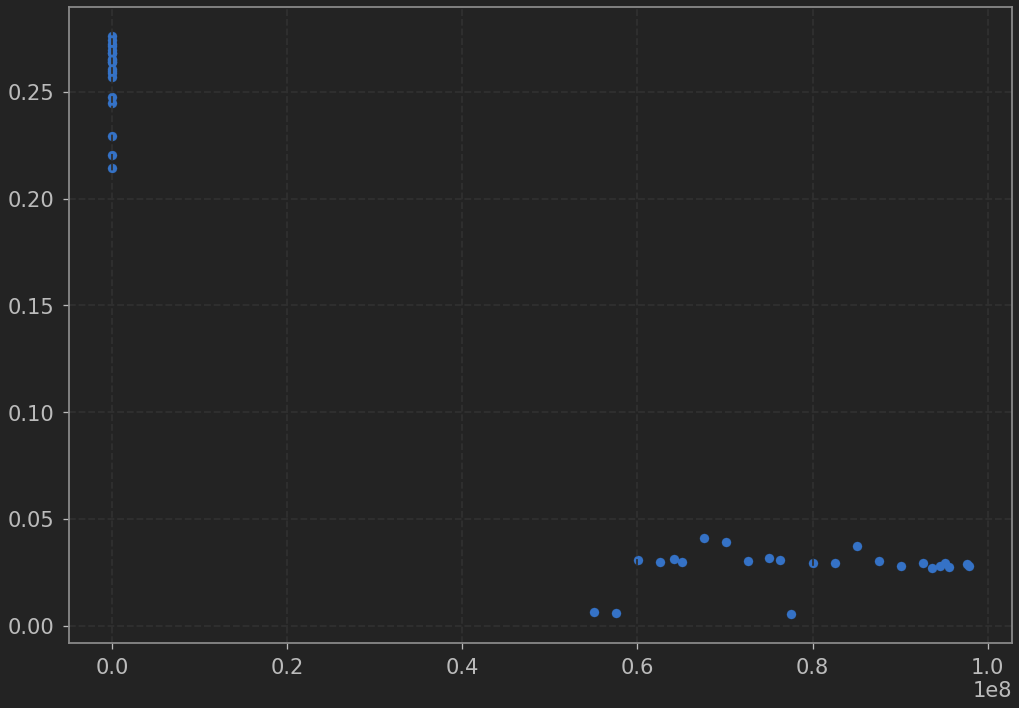

In [78]:
plt.scatter(xen, np.array(xrad) )
# plt.plot(e[40:], cs[40:])
# plt.yscale('log')